<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tayglobal/kinyu-demo/blob/master/notebooks/IR_Risk_in_Multicurve_Env.ipynb"><img src="https://files.tayglobal.com/images/icons/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tayglobal/kinyu-demo/blob/master/notebooks/IR_Risk_in_Multicurve_Env.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://files.tayglobal.com/blog/2020-07-31/IR+Risk+in+Multicurve+Env.html"><img src="https://files.tayglobal.com/images/icons/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Author: [Tony Yum](https://www.linkedin.com/in/tonyyum/)

# IR Risk in Multi-curve environment

Having sat next to some rates trader and seeing the system they use to understand, hedge or profit from their risk, I often thought it would be fun to build that system. Of course the bank has poured millions of dollar into such system so I will not be making a clone. Instead I want to show (what you already know) how powerful and expressive python can be. With a Jupyter notebook I will show how you could build a poor man’s version.


Not only does it show how little code is required, but it will also show how easy it is in python to visualise your data on each step of the way to your goal. 

I will be using QuantLib for bootstrapping and pricing, Pandas/Matplotlib for visualising tabula and plotting respectively.

## The steps

1. Load market data
2. Build OIS and 6M curve
3. Price a 6 Month Swap
4. Show the sensitivity of the swap on each instruments used to build the curve.
5. Show the risk of a portfolio with 100 swaps with different settlement date, maturity and notional (long and short)

In [ ]:
#@title Install Libraries
!pip install QuantLib-Python

## Importing and initialising pricing environment

In [ ]:
import copy
import itertools
import json
import QuantLib as ql
import numpy as np
import pandas as pd
import random
import requests
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
calendar = ql.TARGET()
todaysDate = ql.Date(11, ql.December, 2012)
ql.Settings.instance().evaluationDate = todaysDate

fixingDays = 2
settlementDate = calendar.advance(todaysDate, fixingDays, ql.Days)

## Reading the market data

Read the market data from JSON files

In [ ]:
MARKETDATA_BASE = 'https://raw.githubusercontent.com/jiujitsu-sekai/kinyu-demos/master/data/'

def get_marketdata(filename: str):
    return requests.get(url=MARKETDATA_BASE + filename).json()

In [ ]:
eonia_marketdata = get_marketdata('eonia_marketdata.json')
euribor6M_marketdata = get_marketdata('euribor6M_marketdata.json')

The market data looks like he below

In [ ]:
eonia_marketdata

{'data': {'DATED': [['16-January-2013', '13-February-2013', 0.00046],
   ['13-February-2013', '13-March-2013', 0.00016],
   ['13-March-2013', '10-April-2013', -7e-05],
   ['10-April-2013', '8-May-2013', -0.00013],
   ['8-May-2013', '12-June-2013', -0.00014]],
  'DEPOSIT': [[0, [1, 'Days'], 0.0004],
   [1, [1, 'Days'], 0.0004],
   [2, [1, 'Days'], 0.0004]],
  'SWAPS': [[2, [15, 'Months'], 2e-05],
   [2, [18, 'Months'], 8e-05],
   [2, [21, 'Months'], 0.00021],
   [2, [2, 'Years'], 0.00036],
   [2, [3, 'Years'], 0.00127],
   [2, [4, 'Years'], 0.00274],
   [2, [5, 'Years'], 0.00456],
   [2, [6, 'Years'], 0.00647],
   [2, [7, 'Years'], 0.00827],
   [2, [8, 'Years'], 0.00996],
   [2, [9, 'Years'], 0.01147],
   [2, [10, 'Years'], 0.0128],
   [2, [11, 'Years'], 0.01404],
   [2, [12, 'Years'], 0.01516],
   [2, [15, 'Years'], 0.01764],
   [2, [20, 'Years'], 0.01939],
   [2, [25, 'Years'], 0.02003],
   [2, [30, 'Years'], 0.02038]],
  'SWAPS_SHORT_END': [[2, [1, 'Weeks'], 0.0007],
   [2, [2, 'Week

But why not make it look pretty. Let's put it into pandas and add some formatting and styling.

In [ ]:
def market_data_row(inst_type, row):
    rate = row[-1]
    if inst_type == 'DATED':
        return (inst_type, row[0], row[1], rate)
    elif inst_type == 'FRA':
        return (inst_type, f'FRA #{row[0]}', None, rate)
    else:
        return (inst_type, row[0], ' '.join(map(str, row[1])), rate)
    
INST_TYPE_COLOR_MAP = {
    'DEPOSIT': 'white',
    'SWAPS_SHORT_END': 'lightgreen',
    'FRA': 'lightblue',
    'DATED': 'lightblue',
    'SWAPS': 'pink',
}

def inst_type_pd_style(s):
    return 'background-color: %s' % INST_TYPE_COLOR_MAP[s]

bp = 0.0001

def rates_as_bps(rate):
    return rate / bp

def display_market_data(market_data):
    
    data = list(itertools.chain.from_iterable(
        iter(market_data_row(t, x) for x in market_data['data'][t]) for t in market_data['types']))

    df = pd.DataFrame(data, columns=['Instrument', 'Start', 'End', 'Rate'])
    df['Rate'] /= bp

    return df.style.applymap(inst_type_pd_style, subset=pd.IndexSlice[:, 'Instrument']
                     ).format({'Rate':'{:0.1f}'})

### EONIA Market Data

In [ ]:
display_market_data(eonia_marketdata)

,Instrument,Start,End,Rate
0,DEPOSIT,0,1 Days,4.0
1,DEPOSIT,1,1 Days,4.0
2,DEPOSIT,2,1 Days,4.0
3,SWAPS_SHORT_END,2,1 Weeks,7.0
4,SWAPS_SHORT_END,2,2 Weeks,6.9
5,SWAPS_SHORT_END,2,3 Weeks,7.8
6,SWAPS_SHORT_END,2,1 Months,7.4
7,DATED,16-January-2013,13-February-2013,4.6
8,DATED,13-February-2013,13-March-2013,1.6
9,DATED,13-March-2013,10-April-2013,-0.7


### 6M EURIBOR

In [ ]:
display_market_data(euribor6M_marketdata)

,Instrument,Start,End,Rate
0,DEPOSIT,3,6 Months,31.2
1,FRA,FRA #1,None,29.3
2,FRA,FRA #2,None,27.2
3,FRA,FRA #3,None,26.0
4,FRA,FRA #4,None,25.6
5,FRA,FRA #5,None,25.2
6,FRA,FRA #6,None,24.8
7,FRA,FRA #7,None,25.4
8,FRA,FRA #8,None,26.1
9,FRA,FRA #9,None,26.7


## Define the curves

Now let's build the curves.

### EONIA

For Eonia, we're going to take deposit, dated and swap insturments to bootstrap the curve.

*Deposit*

In [ ]:
dayCounter = ql.Actual360()

def getPeriod(n, unit):
    return ql.Period(n, getattr(ql, unit))

def getDepositHelpers(settlementDays, period, rate):
    return ql.DepositRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(rate)),
        getPeriod(*period),
        settlementDays,
        calendar,
        ql.ModifiedFollowing,
        False,
        dayCounter,
    )

*Swaps*

In [ ]:
eonia = ql.Eonia()

def getOISRateHelper(settlementDays, period, rate):
    return ql.OISRateHelper(
        settlementDays,
        getPeriod(*period),
        ql.QuoteHandle(ql.SimpleQuote(rate)),
        eonia
    )

*Dated*

In [ ]:
def getQlDate(s):
    d, m, y = s.split('-')
    return ql.Date(int(d), getattr(ql, m), int(y))

def getDatedOISRateHelper(startDate, endDate, rate):
    return ql.DatedOISRateHelper(
        getQlDate(startDate),
        getQlDate(endDate),
        ql.QuoteHandle(ql.SimpleQuote(rate)),
        eonia
    )

Let's build the curve.

In [ ]:
tolerance = 1.0e-15

def getOISTermStructure(depositRates, oisCashRates, oisFutRates, oisSwapRates):
    depositHelpers = [getDepositHelpers(*x) for x in depositRates]
    oisCashRateHelpers = [getDepositHelpers(*x) for x in oisCashRates]
    datedOISRateHelper = [getDatedOISRateHelper(*x) for x in oisFutRates]
    oisSwapRateHelpers = [getOISRateHelper(*x) for x in oisSwapRates]

    helpers = depositHelpers + oisCashRateHelpers + datedOISRateHelper + oisSwapRateHelpers
    res = ql.PiecewiseLogCubicDiscount(todaysDate, helpers, ql.Actual365Fixed(),
                                                         ql.IterativeBootstrap(accuracy=tolerance))
    res.enableExtrapolation()
    return res

eoniaTermStructure = getOISTermStructure(*[eonia_marketdata['data'][x] for x in eonia_marketdata['types']])

We can now use *discountingTermStructure* to discount cashflows when pricing a swap

In [ ]:
def getRelinkableYieldTermStructureHandle(termStructure):
    res = ql.RelinkableYieldTermStructureHandle()
    res.linkTo(termStructure)
    return res

discountingTermStructure = getRelinkableYieldTermStructureHandle(eoniaTermStructure)

### 6M EURIBOR

We'll do something similar with 6M EURIBOR.
Deposit Helper is identical to that of the EONIA.
We need to define helper for FRA and Swaps

*FRA*

In [ ]:
euribor6M = ql.Euribor6M()

def getFraHelper(start, _end, rate):
    return ql.FraRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(rate)),
        start,
        euribor6M
    )
      


*Swaps*

In [ ]:
swFixedLegFrequency = ql.Annual
swFixedLegConvention = ql.Unadjusted;
swFixedLegDayCounter = ql.Thirty360(ql.Thirty360.European)

In [ ]:
def getSwapRateHelper(settlementDays, period, rate):
    return ql.SwapRateHelper(
            ql.QuoteHandle(ql.SimpleQuote(rate)),
            getPeriod(*period),
            calendar,
            swFixedLegFrequency,
            swFixedLegConvention,
            swFixedLegDayCounter,
            euribor6M,
            ql.QuoteHandle(),
            ql.Period("0D"),
            discountingTermStructure,
        )

Now we'll build 6M EURIBOR curve as our forcasting curve

In [ ]:
def getForecastingTermStructure(euribor6M_deposit, euribor6M_fra, euribor6M_swap):
    euribor6M_deposit_helpers = [getDepositHelpers(*x) for x in euribor6M_deposit]
    euribor6M_fra_helpers = [getFraHelper(*x) for x in euribor6M_fra]
    euribor6M_swap_helpers = [getSwapRateHelper(*x) for x in euribor6M_swap]
    euribor6M_helpers = euribor6M_deposit_helpers + euribor6M_fra_helpers + euribor6M_swap_helpers
    return ql.PiecewiseLogCubicDiscount(todaysDate, euribor6M_helpers, swFixedLegDayCounter,
                                                         ql.IterativeBootstrap(accuracy=tolerance))
euribor6MTermStructure = getForecastingTermStructure(
    *[euribor6M_marketdata['data'][x] for x in euribor6M_marketdata['types']])
forecastingTermStructure = getRelinkableYieldTermStructureHandle(euribor6MTermStructure)

## Visualising the Curve

The best way to get a feel of the curve is to plot it. Let's do that.

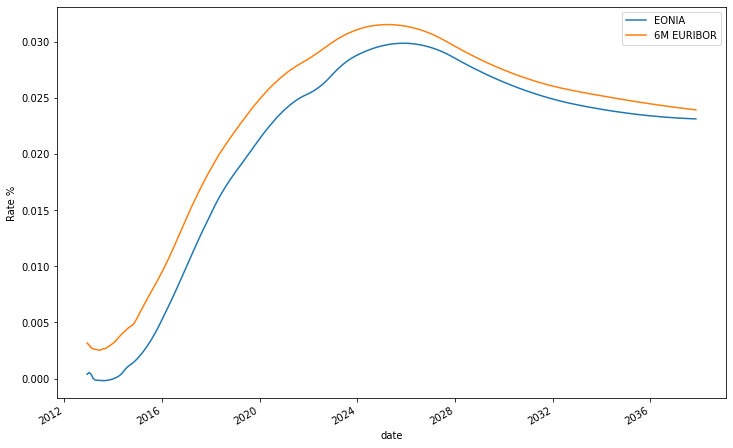

In [ ]:
def get_curve_dataframe(curve, period, label):
    data = []
    for i in range(12 * 25):
        dt = calendar.advance(curve.referenceDate(), i, ql.Months)
        rate = curve.forwardRate(dt, calendar.advance(dt, period[0], period[1]), curve.dayCounter(), ql.Simple).rate()
        data.append((np.datetime64(dt.to_date()), rate))

    return pd.DataFrame(data, columns=['date', label]).set_index('date')


plt.figure(figsize=(12,8))
ax = plt.subplot(111)

get_curve_dataframe(eoniaTermStructure, (1, ql.Days), 'EONIA').plot(ax=ax)
get_curve_dataframe(euribor6MTermStructure, (6, ql.Months), '6M EURIBOR').plot(ax=ax)
plt.ylabel('Rate %')
plt.show()

## Creating the swap

Create a swap pricing engine

In [ ]:
swapEngine = ql.DiscountingSwapEngine(discountingTermStructure)

Define a function that creates a swap

In [ ]:
def create_swap(nominal = 1000000., len_in_years=5, days_to_settlement=2):   
    # Fixed leg
    fixedLegFrequency = ql.Annual;
    fixedLegConvention = ql.Unadjusted;
    floatingLegConvention = ql.ModifiedFollowing;
    fixedLegDayCounter = ql.Thirty360(ql.Thirty360.European);
    fixedRate = 0.007;
    floatingLegDayCounter = ql.Actual360()
    floatingLegFrequency = ql.Semiannual
    euriborIndex = ql.Euribor6M(forecastingTermStructure)
    spread = 0;
    lengthInYears = 5;
    swapType = ql.VanillaSwap.Payer;

    settlementDate = calendar.advance(todaysDate, days_to_settlement, ql.Days)
    maturity = calendar.advance(settlementDate, len_in_years, ql.Years)

    fixedSchedule = ql.Schedule(
        settlementDate,
        maturity,
        ql.Period(fixedLegFrequency),
        calendar,
        fixedLegConvention,
        fixedLegConvention,
        ql.DateGeneration.Forward,
        False,
    )
    floatSchedule = ql.Schedule(
        settlementDate,
        maturity,
        ql.Period(floatingLegFrequency),
        calendar,
        floatingLegConvention,
        floatingLegConvention,
        ql.DateGeneration.Forward,
        False,
    )
    
    swap = ql.VanillaSwap(swapType, nominal,
            fixedSchedule, fixedRate, fixedLegDayCounter,
            floatSchedule, euriborIndex, spread,
            floatingLegDayCounter)

    swap.setPricingEngine(swapEngine)
    return swap

Create a 5 year spot starting swap

In [ ]:
spot5YearSwap = create_swap()

## Visualising the swap

Let's have some fun visualising what this swap's economics looks like. We'll:

* Plot each cashflow with x axis as the date and y as the amount.
* Plot cashflow for both fixed and floating leg
* Plot also the discounted cashflow
* Add a line to show the cumulative sum of the discounted cashflow.

We shall expect that the sum of the cashflow to equal to the price of the swap.

So, we'll verify with an assertion that quantlib agrees with our calculation.

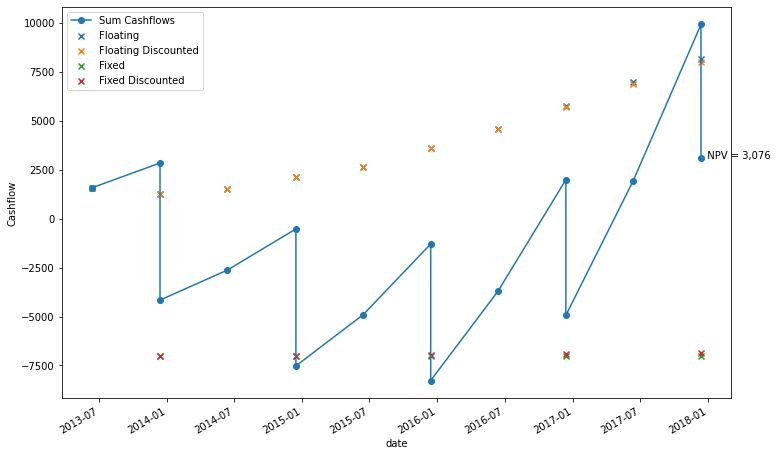

In [ ]:
def plot_cashflows(cashflows, direction, discounted, label):
    xs = [np.datetime64(x.date().to_date()) for x in cashflows]
    ys = [x.amount() * direction * (discountingTermStructure.discount(x.date()) if discounted else 1) for x in cashflows]
    plt.scatter(xs, ys, marker='x', label=label)
    
def get_cashflows(cashflows, direction):
    return [(np.datetime64(x.date().to_date()), x.amount() * direction * discountingTermStructure.discount(x.date())
            ) for x in cashflows]

plt.figure(figsize=(12,8))
plot_cashflows(spot5YearSwap.floatingLeg(), 1, False, 'Floating')
plot_cashflows(spot5YearSwap.floatingLeg(), 1, True, 'Floating Discounted')
plot_cashflows(spot5YearSwap.fixedLeg(), -1, False, 'Fixed')
plot_cashflows(spot5YearSwap.fixedLeg(), -1, True, 'Fixed Discounted')

data = get_cashflows(spot5YearSwap.floatingLeg(), 1) + get_cashflows(spot5YearSwap.fixedLeg(), -1)
ts = pd.DataFrame(data, columns=['date', 'Cashflow']).sort_values('date').set_index('date').Cashflow

ts.cumsum().plot(marker='o', label='Sum Cashflows')
npv = ts.sum()
# We confirm that summing the cashflows does reproduce the NPV per calculation by quantlib
assert(abs(npv - spot5YearSwap.NPV()) < 0.00001)
plt.text(ts.index[-1], npv, f'  NPV = {npv:,.0f}')
plt.ylabel('Cashflow')
plt.legend()
plt.show()


## IR RIsk

Here we will show how we could get the sensitivity to the market risk factors.

First we'll create a function to bump the market. We verify that it does what we want by bumping the 5 year EONIA swap.

In [ ]:
bump_amt = 1e-7
def bump_rate(rates, i):
    ratesCopy = copy.copy(rates)
    start, period, rate = ratesCopy[i]
    ratesCopy[i] = (start, period, rate + bump_amt)
    return ratesCopy

def get_bumped_marketdata(market_data, market_data_type, i):
    mds = iter((t, market_data['data'][t]) for t in market_data['types'])
    return [bump_rate(md, i) if t == market_data_type else md \
            for t, md in mds]
    
tenor_to_bump = 6
print('Before bump: {}'.format(eonia_marketdata['data']['SWAPS'][tenor_to_bump]))
# Let's bump the 5 years swaps rates
bumped =  get_bumped_marketdata(eonia_marketdata, 'SWAPS', tenor_to_bump)
print('After bump: {}'.format(bumped[3][tenor_to_bump]))

Before bump: [2, [5, 'Years'], 0.00456]
After bump: (2, [5, 'Years'], 0.0045601)


Next we create a function that calculates the impact of the swap price on a delta change in the underlying risk factor. 

This is done by calculating the price before and after a market data bump.

We'll bump the 5Y EONIA swap to see how it impact our 5Y 6M-EURIBOR Swap.

In [ ]:
def calc_sensitivity(priceable, curve, curve_builder, orig_term_structure,
                     market_data, market_data_type, i):
    basePV = priceable.NPV()
    bumped_term_structure = curve_builder(
        *get_bumped_marketdata(market_data, market_data_type, i))
    curve.linkTo(bumped_term_structure)
    after = priceable.NPV()
    # Undo the bump
    curve.linkTo(orig_term_structure)
    return (after - basePV) / bump_amt

calc_sensitivity(spot5YearSwap, discountingTermStructure, getOISTermStructure,
                eoniaTermStructure, eonia_marketdata, 'SWAPS', tenor_to_bump)

-3106.366202700883

Now to see the full laddered risk we create a couple of functions
to bump each point of each instrument type and calculate the 
sensitivity.

The result would return a Pandas dataframe.

In [ ]:
def calc_sensitivity_by_type(priceable, curve, curve_builder, orig_term_structure,
                             market_data, market_data_type):
    res = []    
    md = market_data['data'][market_data_type]
    for i, row in enumerate(md):
        sensitivity = calc_sensitivity(priceable, curve, curve_builder, orig_term_structure,
                                       market_data, market_data_type, i)
        if market_data_type == 'DATED':
            start_dt, end_dt = row[:2]
        elif market_data_type == 'FRA':
            start_dt = f'FRA #{row[0]}'
            end_dt = None
        else:
            start_dt = row[0]
            end_dt = ' '.join(map(str, row[1]))
            
        res.append((market_data_type, start_dt, end_dt, sensitivity))
        
    return res

def calc_market_ladder_sensitivity(priceable, curve, curve_builder, orig_term_structure,
                                   market_data):
    data = list(itertools.chain.from_iterable(
        (calc_sensitivity_by_type(
            priceable, curve, curve_builder, orig_term_structure, market_data, x) \
         for x in market_data['types'])))

    return pd.DataFrame(data, columns=['Type', 'Start', 'End', 'BPV'])

Let's see the risk against the 6M-EURIBOR curve. 

Since we have no sensitivity to most the points, we'll filter out only risk more than 1 EUR.

```python
df[df.BPV.abs() > 1]
```

Very unsurprisingly a 1MM notional 5Y 6M-EURIBOR swap would have close to 5MM BPV to a 6M-EURIBOR. It will not be exact as our swap is spot starting.

In [ ]:
df = calc_market_ladder_sensitivity(
    spot5YearSwap, forecastingTermStructure, getForecastingTermStructure,
    euribor6MTermStructure, euribor6M_marketdata)

df[df.BPV.abs() > 1].style.format({'BPV':'{:0.0f}'}).background_gradient(cmap='Reds')

,Type,Start,End,BPV
21,SWAPS,0,5 Years,4961355


Now let's see our laddered risk against funding spread. This would look more interesting as each coupon's NPV would be impacted by the discount factor.

In [ ]:
df = calc_market_ladder_sensitivity(
    spot5YearSwap, discountingTermStructure, getOISTermStructure,
    eoniaTermStructure, eonia_marketdata)

df[df.BPV.abs() > 1].style.format({'BPV':'{:0.0f}'}).background_gradient(cmap='Reds_r')

,Type,Start,End,BPV
0,DEPOSIT,0,1 Days,-9
1,DEPOSIT,1,1 Days,-9
5,SWAPS_SHORT_END,2,3 Weeks,2
6,SWAPS_SHORT_END,2,1 Months,-19
7,DATED,16-January-2013,13-February-2013,-15
8,DATED,13-February-2013,13-March-2013,-13
9,DATED,13-March-2013,10-April-2013,-18
11,DATED,8-May-2013,12-June-2013,-68
12,SWAPS,2,15 Months,-868
13,SWAPS,2,18 Months,491


## Portfolio of swaps

A trader is unlikely to have just 1 swap in their portfolio. Let's generate 100 random swaps at different settlement date, maturity and notional (both long and short)

We'll display just 10 of them.

In [ ]:
random.seed(278346237846)
years_range = (1, 25)
settlement_range = (2, 365)
notional_range = (1, 5000)
notional_unit = 1000

rr = random.randrange

swaps_data = [(
    rr(*notional_range) * notional_unit * random.choice([1, -1]),
    rr(*years_range),
    rr(*settlement_range)
 ) for _ in range(100)]

pd.DataFrame(swaps_data[:10], columns=['Notional', 'Years', 'Settlement'])

,Notional,Years,Settlement
0,-4981000,10,114
1,-2788000,21,40
2,2385000,19,322
3,4383000,17,69
4,1241000,14,312
5,1680000,12,343
6,-3638000,22,296
7,-2526000,13,124
8,1291000,7,202
9,-2743000,19,213


Next we'll create a portfolio is that priceable and riskable.

In [ ]:
swaps = [create_swap(*x) for x in swaps_data]
class Portfolio:
    def __init__(self, positions):
        self.positions = positions

    def NPV(self):
        return sum(p.NPV() for p in self.positions)
    
portfolio = Portfolio(swaps)        

Let's try pricing the portfolio

In [ ]:
portfolio.NPV()

3130073.36940925

It is impossible for a trader to keep track in their head the 100 swaps that are in their portfolio. In practise they care only the risk of their portfolio. 

So let's see what the risk of this portfolio look like.

This is very useful for trader as they know exactly what to trade to reduce their risk or they can allow risk if it is small or they anticipate the IR term structure would move in their favour.

In [ ]:
df = calc_market_ladder_sensitivity(
    portfolio, forecastingTermStructure, getForecastingTermStructure,
    euribor6MTermStructure, euribor6M_marketdata)

df[df.BPV.abs() > 1].style.format({'BPV':'{:,.0f}'}).background_gradient(cmap='hsv')

,Type,Start,End,BPV
0,DEPOSIT,3,6 Months,"-5,085,745"
1,FRA,FRA #1,None,"8,585,637"
2,FRA,FRA #2,None,"-3,453,870"
3,FRA,FRA #3,None,"-7,236,628"
4,FRA,FRA #4,None,"287,734"
5,FRA,FRA #5,None,"-60,772"
6,FRA,FRA #6,None,"-62,433"
7,FRA,FRA #7,None,"2,589,695"
8,FRA,FRA #8,None,"-3,316,932"
9,FRA,FRA #9,None,"-7,197,970"


The chances are, most of the concern would be at the 6M-EURIBOR, but for
completeness, lets see our risk to funding spread.

In [ ]:
df = calc_market_ladder_sensitivity(
    spot5YearSwap, discountingTermStructure, getOISTermStructure,
    eoniaTermStructure, eonia_marketdata)

df[df.BPV.abs() > 1].style.format({'BPV':'{:,.0f}'}).background_gradient(cmap='hsv')

,Type,Start,End,BPV
0,DEPOSIT,0,1 Days,-9
1,DEPOSIT,1,1 Days,-9
5,SWAPS_SHORT_END,2,3 Weeks,2
6,SWAPS_SHORT_END,2,1 Months,-19
7,DATED,16-January-2013,13-February-2013,-15
8,DATED,13-February-2013,13-March-2013,-13
9,DATED,13-March-2013,10-April-2013,-18
11,DATED,8-May-2013,12-June-2013,-68
12,SWAPS,2,15 Months,-868
13,SWAPS,2,18 Months,491


## Conclusion

As we can see. It does not take much work to implement a basic risk engine.

However this is far from what is used in practise. Just to name a few points.

* On a large portfolio we would need to distribute the compute in a cluster
* A dollar bank is likely going to be funded in USD and we need to take XCCY basis swaps into account.
* What we showed is what's call a market ladder where the data points are market data.
  * This is good for hedging and estimating realtime PNL.
  * Not good to compare risk accross different curves that uses different instruments to build.
  * The market risk team would need to see a standard ladder.